# PROJET 4 - Segmentez des clients d'un site e-commerce

# Importation des librairies

In [ ]:
# coding: utf-8

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats
import scipy.stats as st
import matplotlib.lines as mlines
from scipy import stats
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
import re
from math import pi
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster, metrics
from sklearn.cluster import DBSCAN
from matplotlib.collections import LineCollection
from sklearn import decomposition
from sklearn import preprocessing
import timeit
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from scipy.stats import mode
import plotly.express as px
!pip install kmodes
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# Chargement des jeux de données

In [ ]:
data = pd.read_csv('data_segmentation.csv', sep = ",")

In [ ]:
data

,customer_unique_id,date_dernier_achat,date_premier_achat,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,116,1,129.90,1,1.0,Livré,8.456660,5.0,4.0,6.0,1.0,1500.0,7616.0,Local,1.046633,credit_card,8.0,meuble
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,119,1,18.90,1,1.0,Livré,30.489150,4.0,0.0,3.0,1.0,375.0,5148.0,Local,0.215391,credit_card,1.0,sante_et_beaute
2,0000f46a3911fa3c0805444483337064,2017-03-10,2017-03-10,542,1,69.00,1,1.0,Livré,19.972164,3.0,1.0,26.0,3.0,1500.0,43750.0,Non local,4.717804,credit_card,8.0,accessoires
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,2017-10-12,326,1,25.99,1,1.0,Livré,40.417240,4.0,1.0,20.0,5.0,150.0,1045.0,Non local,22.320099,credit_card,4.0,tech
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,2017-11-14,293,1,180.00,1,1.0,Livré,8.578394,5.0,4.0,13.0,3.0,6050.0,528.0,Local,1.511542,credit_card,6.0,tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91696,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,2017-06-08,452,1,1570.00,2,2.0,Livré,24.059939,5.0,4.0,28.0,1.0,30000.0,251625.0,Non local,18.180999,credit_card,10.0,sante_et_beaute
91697,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,2017-12-10,267,1,64.89,1,1.0,Livré,23.279735,4.0,5.0,30.0,2.0,1720.0,32076.0,Non local,14.005715,credit_card,1.0,enfance
91698,ffff371b4d645b6ecea244b27531430a,2017-02-07,2017-02-07,573,1,89.90,1,1.0,Livré,20.060466,5.0,2.0,15.0,5.0,600.0,3315.0,Non local,14.092964,credit_card,1.0,divers
91699,ffff5962728ec6157033ef9805bacc48,2018-05-02,2018-05-02,124,1,115.00,1,1.0,Livré,13.980103,5.0,2.0,12.0,3.0,444.0,4480.0,Non local,6.151068,credit_card,5.0,divers


In [ ]:
data2017 = data[data['date_dernier_achat'] < '2017-12-31 23:59:59']
data2017.reset_index(drop=True, inplace=True)

In [ ]:
data_stab_1_mois = data[data['date_dernier_achat'] < '2018-01-31 23:59:59']
data_stab_1_mois.reset_index(drop=True, inplace=True)

data_stab_2_mois = data[data['date_dernier_achat'] < '2018-02-31 23:59:59']
data_stab_2_mois.reset_index(drop=True, inplace=True)

data_stab_3_mois = data[data['date_dernier_achat'] < '2018-03-31 23:59:59']
data_stab_3_mois.reset_index(drop=True, inplace=True)

data_stab_4_mois = data[data['date_dernier_achat'] < '2018-04-31 23:59:59']
data_stab_4_mois.reset_index(drop=True, inplace=True)

data_stab_5_mois = data[data['date_dernier_achat'] < '2018-05-31 23:59:59']
data_stab_5_mois.reset_index(drop=True, inplace=True)

data_stab_6_mois = data[data['date_dernier_achat'] < '2018-06-31 23:59:59']
data_stab_6_mois.reset_index(drop=True, inplace=True)

data_stab_7_mois = data[data['date_dernier_achat'] < '2018-07-31 23:59:59']
data_stab_7_mois.reset_index(drop=True, inplace=True)

data_stab_8_mois = data[data['date_dernier_achat'] < '2018-08-31 23:59:59']
data_stab_8_mois.reset_index(drop=True, inplace=True)

data_stab_9_mois = data[data['date_dernier_achat'] < '2018-09-31 23:59:59']
data_stab_9_mois.reset_index(drop=True, inplace=True)


# Définition des fonctions

In [ ]:
def creation_data_0(features, data) :

  X_rfm_scaled = data[features]
  X_rfm_scaled = preprocessing.scale(X_rfm_scaled)
  
  return X_rfm_scaled

In [ ]:
def creation_data(features, data, var_quali):
  
  X_amelio_X_scaled = data[features].copy()
  
  labelencoder=LabelEncoder()
  for col in var_quali:
    X_amelio_X_scaled[col] = labelencoder.fit_transform(X_amelio_X_scaled[col])
  
  X_amelio_X_scaled = preprocessing.scale(X_amelio_X_scaled)

  return X_amelio_X_scaled

In [ ]:
def clustering(modele, X_scaled):
  
  ## Calcul des vitesses d'éxécution
  start_time = timeit.default_timer()

  # Clustering par le modèle  
  cls_model = modele.fit(X_scaled)

  elapsed = timeit.default_timer() - start_time

  # Récupération des clusters attribués à chaque individu
  labels = cls_model.labels_

  return cls_model, labels, elapsed

In [ ]:
def repartition(X):
  plt.figure(figsize=(15,10))
  sns.countplot(x = "clusters", data = X, order = sorted(list(X['clusters'].unique())))
  plt.title('Clustering des individus')
  plt.xlabel('Numéro des clusters')
  plt.ylabel('Nombre d\'individus')

In [ ]:
def pd_centers(cols_of_interest, centers):
  colNames = list(cols_of_interest)
  colNames.append('prediction')
# Zip with a column called 'prediction' (index)
  Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame for plotting
  P = pd.DataFrame(Z, columns=colNames)
  P['prediction'] = P['prediction'].astype(int)
  return P

In [ ]:
def evaluation_custering(nom_modele, X_scaled, labels, hyperparametres, temps_execution):
  ## Coefficient de silhouette
  silhouette = metrics.silhouette_score(X_scaled, labels)

  ## Indice de Calinski-Harabasz
  calinski_harabasz_score = metrics.calinski_harabasz_score(X_scaled, labels)

  liste_resultats = [nom_modele, hyperparametres, silhouette, calinski_harabasz_score, temps_execution]

  return liste_resultats

In [ ]:
def data_concat(features, data, labels, nom_clusters):

  data_concat = data[features]
  data_concat = pd.concat([data_concat,pd.DataFrame(labels)], axis=1)
  data_concat.rename(columns={0 : nom_clusters}, inplace = True)
  data_concat[nom_clusters] = data_concat[nom_clusters].astype(str)
  
  return data_concat

In [ ]:
## Fonctions de l'ACP

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# **SEGMENTATION RFM**

In [ ]:
# Préparation des données

features = ['nombre_jours',	'nombre_commande',	'moyenne_prix_commande']
X_rfm = data2017[features]
X_rfm.describe(include='all')

,nombre_jours,nombre_commande,moyenne_prix_commande
count,41042.000000,41042.000000,41042.000000
mean,385.502558,1.028580,142.893104
std,98.969357,0.176842,228.594936
min,246.000000,1.000000,2.290000
25%,294.000000,1.000000,48.000000
50%,370.000000,1.000000,89.000000
75%,461.000000,1.000000,156.000000
max,729.000000,3.000000,13440.000000


## Algorithme du KMeans

In [ ]:
X_rfm_scaled = data2017[features]
X_rfm_scaled = preprocessing.scale(X_rfm_scaled)

In [ ]:
modele = KMeans

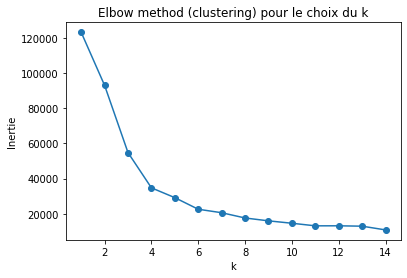

In [ ]:
## Choix de l'hyperparamètre : Méthode Elbow

resultat = []
for i in range(1, 15):
  cls = modele(n_clusters = i, n_init = 1, init = 'random')
  cls.fit(X_rfm_scaled) ## clustering sur les données normalisées
  resultat.append(cls.inertia_)
  
plt.plot(range(1, 15), resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Elbow method (clustering) pour le choix du k')
plt.show()

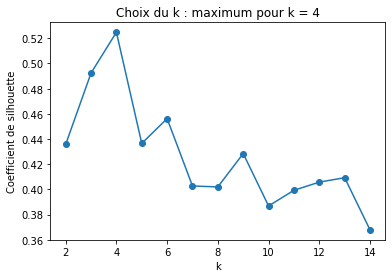

In [ ]:
## Choix de l'hyperparamètre : n_clusters

resultat = []
for i in range(2, 15):
  cls = modele(n_clusters = i, n_init = 1, init = 'random')
  cls.fit(X_rfm_scaled) ## clustering sur les données normalisées
  resultat.append(metrics.silhouette_score(X_rfm_scaled, cls.labels_))
  
plt.plot(range(2, 15), resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Coefficient de silhouette')
plt.title("Choix du k : maximum pour k = {}".format(resultat.index(max(resultat))+2))
plt.show()

In [ ]:
## Choix de n_clust
n_clust_kmeans = 4

In [ ]:
## Clustering du KMeans sur les données de 2017
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

kmeans_clustering = clustering(modele_cls, X_rfm_scaled)
kmeans_modele = kmeans_clustering[0]
labels = kmeans_clustering[1]

In [ ]:
centroids = kmeans_modele.cluster_centers_
print(centroids)

[[-0.70575693 -0.16161811 -0.11045427]
 [ 1.04578889 -0.16161811 -0.11697646]
 [-0.12422904  5.86437205 -0.05474994]
 [ 0.07467681 -0.13860756  4.54344519]]


In [ ]:
P = pd_centers(features, centroids)
P

,nombre_jours,nombre_commande,moyenne_prix_commande,prediction
0,-0.705757,-0.161618,-0.110454,0
1,1.045789,-0.161618,-0.116976,1
2,-0.124229,5.864372,-0.054750,2
3,0.074677,-0.138608,4.543445,3


In [ ]:
X_rfm = pd.concat([X_rfm,pd.DataFrame(labels)], axis=1)
X_rfm.rename(columns={0 : 'clusters'}, inplace = True)
X_rfm['clusters'] = X_rfm['clusters'].astype(str)

## Profils des clients 
profils_kmeans = X_rfm.groupby(['clusters']).agg({'nombre_jours': ['mean', 'std'], 'nombre_commande': ['mean', 'std'], 'moyenne_prix_commande' : ['mean', 'std', 'size']})
profils_kmeans

nombre_jours             ... moyenne_prix_commande       
                 mean        std  ...                   std   size
clusters                          ...                             
0          315.706161  44.146781  ...            108.390278  23244
1          489.085369  60.125911  ...            109.561442  15720
2          373.207840  90.788017  ...            130.293663   1097
3          393.161060  94.281864  ...            767.877152    981

[4 rows x 7 columns]

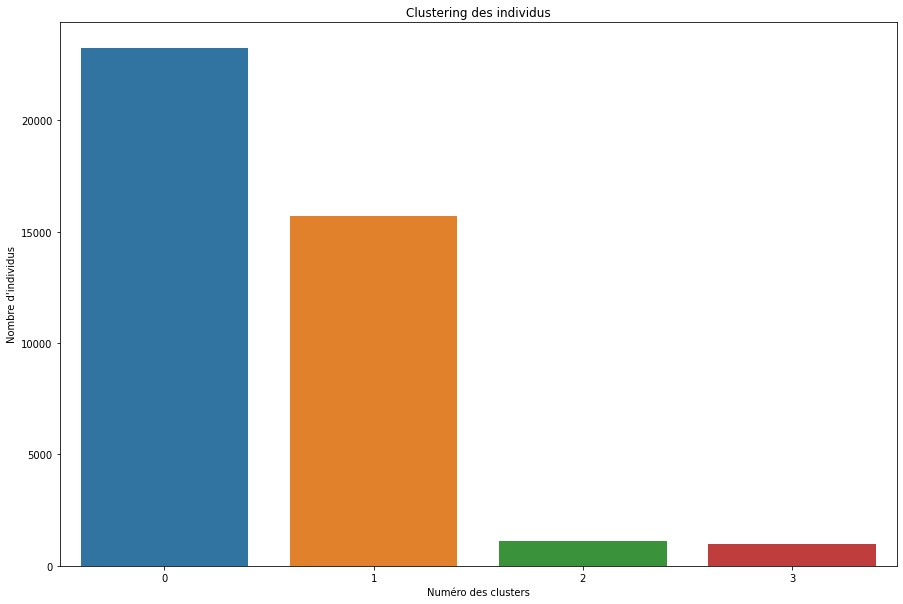

In [ ]:
## Répartition des individus entre les groupes
repartition(X_rfm)

Les résultats de la segmentation avec le KMeans montrent 4 groupes de clients avec les profils suivants : 
* groupe 0 : les clients récents
* groupe 1 : les clients anciens 
* groupe 2 : les clients anciens ayant passé plus d'une commande
* groupe 3 : les clients ayant beaucoup depensé

Les groupes  et 3 sont peu représentés puisqu'on a peu de clients ayant fait plus d'une commande ou avec des montants importants.

In [ ]:
## Evaluation du clustering
resultats_KMeans = evaluation_custering('KMeans', X_rfm_scaled, labels, {'n_clusters' : n_clust_kmeans}, kmeans_clustering[2])

## Algorithme du DBSCAN

In [ ]:
features = ['nombre_jours',	'nombre_commande',	'moyenne_prix_commande']
X_rfm = data2017[features]

In [ ]:
X_rfm_scaled = data2017[features]
X_rfm_scaled = preprocessing.scale(X_rfm_scaled)

In [ ]:
modele = DBSCAN

In [ ]:
## Choix des hyperparamètres : eps et min_samples

x_eps = [i/10 for i in list(range(2, 15))]
tab_hyperparametres = pd.DataFrame(columns=['eps','min_samples', 'coeff_silhouette'])

for j in range(1, 11):
  for i in x_eps:
    cls = modele(eps = i, min_samples = j)
    cls.fit(X_rfm_scaled) ## clustering sur les données normalisées
    tab_hyperparametres = tab_hyperparametres.append({'eps' : i, 'min_samples' : j, 'coeff_silhouette' : metrics.silhouette_score(X_rfm_scaled, cls.labels_)} , ignore_index=True)

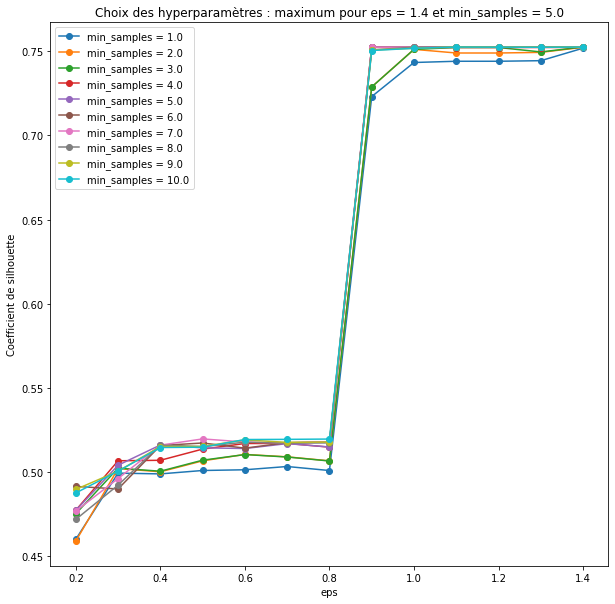

In [ ]:
plt.figure(figsize=(10,10))
for j in list(tab_hyperparametres['min_samples'].unique()):
  plt.plot(x_eps, list(tab_hyperparametres[tab_hyperparametres['min_samples'] == j]['coeff_silhouette']), 'o-', label='min_samples = {}'.format(j))
plt.legend()
plt.xlabel('eps')
plt.ylabel('Coefficient de silhouette')
plt.title("Choix des hyperparamètres : maximum pour eps = {} et min_samples = {}".format(tab_hyperparametres[tab_hyperparametres['coeff_silhouette'] == tab_hyperparametres['coeff_silhouette'].max()]['eps'].values[0], tab_hyperparametres[tab_hyperparametres['coeff_silhouette'] == tab_hyperparametres['coeff_silhouette'].max()]['min_samples'].values[0]))
plt.show()

In [ ]:
## Choix de eps et min_samples
eps_choisi = 0.9 
min_samples_choisi = 7

In [ ]:
## Clustering du DBSCAN sur les données de 2017
modele_cls = modele(eps = eps_choisi, min_samples = min_samples_choisi)

DBSCAN_clustering = clustering(modele_cls, X_rfm_scaled)
DBSCAN_modele = DBSCAN_clustering[0]
labels = DBSCAN_clustering[1]

In [ ]:
X_rfm = pd.concat([X_rfm, pd.DataFrame(labels)], axis=1)
X_rfm.rename(columns={0 : 'clusters'}, inplace = True)
X_rfm['clusters'] = X_rfm['clusters'].astype(str)

## Profils des clients 
profils_DBSCAN = X_rfm.groupby(['clusters']).agg({'nombre_jours': ['mean', 'std'], 'nombre_commande': ['mean', 'std'], 'moyenne_prix_commande' : ['mean', 'std', 'size']})
profils_DBSCAN

nombre_jours              ... moyenne_prix_commande       
                 mean         std  ...                   std   size
clusters                           ...                             
-1         481.269231  135.180637  ...           2728.706062     26
0          385.793097   99.129022  ...            201.233271  39922
1          371.697652   89.151444  ...            127.787069   1022
2          385.777778   99.244927  ...             96.279744     72

[4 rows x 7 columns]

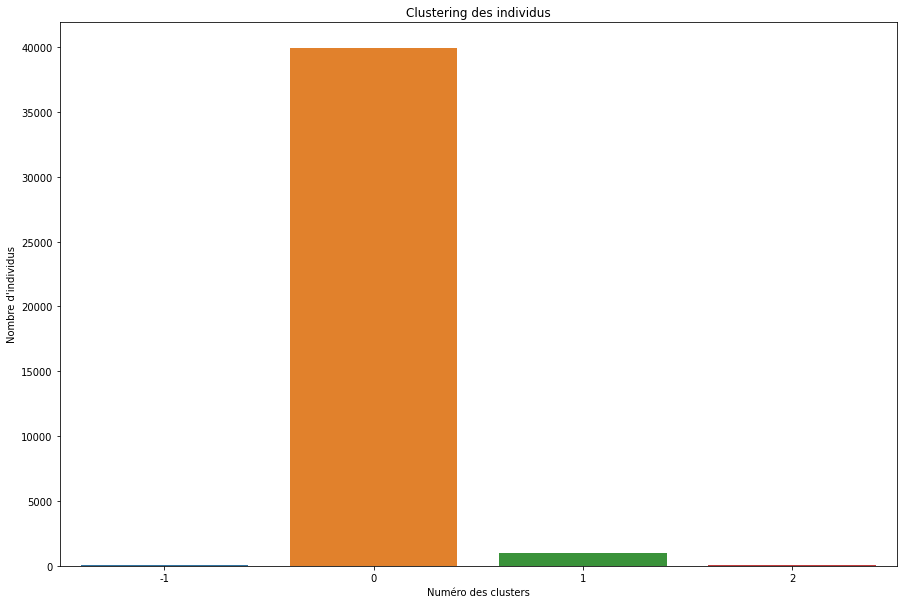

In [ ]:
## Répartition des individus entre les groupes
repartition(X_rfm)

Les résultats de la segmentation avec le DBSCAN montrent 3 groupes de clients avec les profils suivants (le label -1 correspond au bruit) : 
* groupe 0 : les clients ayant fait une seule commande et ayant un peu plus dépensé
* groupe 1 : les clients ayant fait 2 commandes
* groupe 2 : les clients ayant fait 3 commandes

Les groupes 1 et 2 sont peu représentés puisqu'ils correspondent aux clients ayant fait plus de 2 commandes.

In [ ]:
## Evaluation du clustering
resultats_DBSCAN = evaluation_custering('DBSCAN', X_rfm_scaled, labels, {'eps' : eps_choisi, 'min_samples' : min_samples_choisi}, DBSCAN_clustering[2])

## Comparaison des modèles

In [ ]:
tab_resultats_1 = pd.DataFrame(np.nan, index=np.arange(0), columns=['Modèle', 'nombre_paramètre', 'Coefficient_silhouette', 'Indice_Calinski_Harabasz', 'Temps_execution']) 
tab_resultats_1

,Modèle,nombre_paramètre,Coefficient_silhouette,Indice_Calinski_Harabasz,Temps_execution


In [ ]:
tab_resultats_1.loc[0] = resultats_KMeans
tab_resultats_1.loc[1] = resultats_DBSCAN
tab_resultats_1

,Modèle,nombre_paramètre,Coefficient_silhouette,Indice_Calinski_Harabasz,Temps_execution
0,KMeans,{'n_clusters': 4},0.524822,34764.175674,0.817058
1,DBSCAN,"{'eps': 0.9, 'min_samples': 7}",0.752406,8484.607108,17.022406


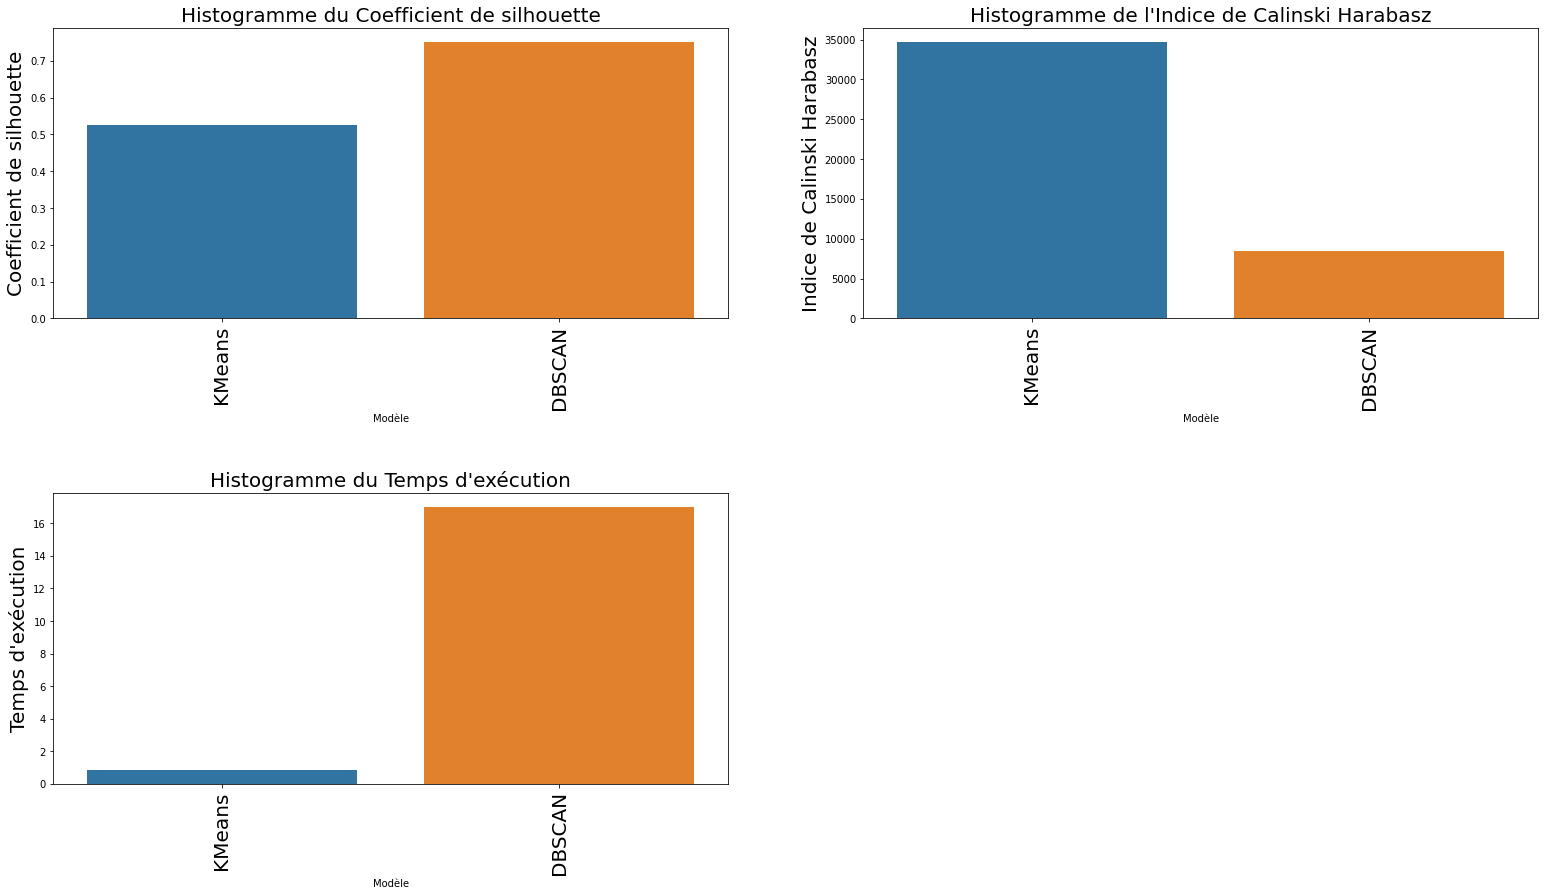

In [ ]:
plt.figure(figsize=(15,15))

plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.2, hspace = 0.6)

plt.subplot(2,2,1)
sns.barplot(x=tab_resultats_1['Modèle'],y=tab_resultats_1['Coefficient_silhouette'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Coefficient de silhouette", fontsize=20)
plt.title('Histogramme du Coefficient de silhouette', fontsize=20)

plt.subplot(2,2,2)
sns.barplot(x=tab_resultats_1['Modèle'],y=tab_resultats_1['Indice_Calinski_Harabasz'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Indice de Calinski Harabasz", fontsize=20)
plt.title('Histogramme de l\'Indice de Calinski Harabasz', fontsize=20)

plt.subplot(2,2,3)
sns.barplot(x=tab_resultats_1['Modèle'],y=tab_resultats_1['Temps_execution'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Temps d\'exécution", fontsize=20)
plt.title('Histogramme du Temps d\'exécution', fontsize=20)

plt.show()

Le modèle optimal sélectionné pour les indicateurs RFM est le KMeans puisque la segmentation DBSCAN est pauvre en différences entre les profils et ne se base que sur le nombre de commandes réalisées. Les profils de clients obtenus avec le KMeans sont plus exploitables. 

## Etude de la stabilité

In [ ]:
## Création des différents DataFrames
features = ['nombre_jours',	'nombre_commande',	'moyenne_prix_commande']

X_rfm_2017_scaled = creation_data_0(features, data2017)
X_rfm_1_mois_scaled = creation_data_0(features, data_stab_1_mois)
X_rfm_2_mois_scaled = creation_data_0(features, data_stab_2_mois)
X_rfm_3_mois_scaled = creation_data_0(features, data_stab_3_mois)
X_rfm_4_mois_scaled = creation_data_0(features, data_stab_4_mois)
X_rfm_5_mois_scaled = creation_data_0(features, data_stab_5_mois)
X_rfm_6_mois_scaled = creation_data_0(features, data_stab_6_mois)
X_rfm_7_mois_scaled = creation_data_0(features, data_stab_7_mois)
X_rfm_8_mois_scaled = creation_data_0(features, data_stab_8_mois)
X_rfm_9_mois_scaled = creation_data_0(features, data_stab_9_mois)

In [ ]:
## Modèle sélectionné

modele = KMeans
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

In [ ]:
features = ['customer_unique_id', 'nombre_jours',	'nombre_commande',	'moyenne_prix_commande']

## Jointure des labels aux différentes périodes de temps sur le DataFrame de 2017

labels = clustering(modele_cls, X_rfm_2017_scaled)[1]
data_0 = data_concat(features, data2017, labels, 'clusters')

labels = clustering(modele_cls, X_rfm_1_mois_scaled)[1]
data_1_mois = data_concat(features, data_stab_1_mois, labels, 'clusters_1_mois')
data_0 = data_0.merge(data_1_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_2_mois_scaled)[1]
data_2_mois = data_concat(features, data_stab_2_mois, labels, 'clusters_2_mois')
data_0 = data_0.merge(data_2_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_3_mois_scaled)[1]
data_3_mois = data_concat(features, data_stab_3_mois, labels, 'clusters_3_mois')
data_0 = data_0.merge(data_3_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_4_mois_scaled)[1]
data_4_mois = data_concat(features, data_stab_4_mois, labels, 'clusters_4_mois')
data_0 = data_0.merge(data_4_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_5_mois_scaled)[1]
data_5_mois = data_concat(features, data_stab_5_mois, labels, 'clusters_5_mois')
data_0 = data_0.merge(data_5_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_6_mois_scaled)[1]
data_6_mois = data_concat(features, data_stab_6_mois, labels, 'clusters_6_mois')
data_0 = data_0.merge(data_6_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_7_mois_scaled)[1]
data_7_mois = data_concat(features, data_stab_7_mois, labels, 'clusters_7_mois')
data_0 = data_0.merge(data_7_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_8_mois_scaled)[1]
data_8_mois = data_concat(features, data_stab_8_mois, labels, 'clusters_8_mois')
data_0 = data_0.merge(data_8_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_rfm_9_mois_scaled)[1]
data_9_mois = data_concat(features, data_stab_9_mois, labels, 'clusters_9_mois')
data_0 = data_0.merge(data_9_mois, on = features, how = 'inner')

data_0

,customer_unique_id,nombre_jours,nombre_commande,moyenne_prix_commande,clusters,clusters_1_mois,clusters_2_mois,clusters_3_mois,clusters_4_mois,clusters_5_mois,clusters_6_mois,clusters_7_mois,clusters_8_mois,clusters_9_mois
0,0000f46a3911fa3c0805444483337064,542,1,69.00,1,3,2,1,3,1,3,1,2,2
1,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,1,3,0,2,1,3,1,2,2
2,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,1,3,0,2,0,0,0,2,2
3,0005e1862207bf6ccc02e4228effd9a0,548,1,135.00,1,3,2,1,3,1,3,1,2,2
4,0006fdc98a402fceb4eb0ee528f6a8d4,412,1,13.90,1,3,2,1,3,1,3,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41037,fffb09418989a0dbff854a28163e47c6,260,1,58.00,0,1,3,0,2,0,0,0,1,1
41038,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,3,0,0,2,0,3,2,3,3,3
41039,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,0,1,3,0,2,0,0,0,2,2
41040,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,3,2,1,3,1,3,1,2,2


In [ ]:
data_0.isnull().sum(axis = 0)

customer_unique_id       0
nombre_jours             0
nombre_commande          0
moyenne_prix_commande    0
clusters                 0
clusters_1_mois          0
clusters_2_mois          0
clusters_3_mois          0
clusters_4_mois          0
clusters_5_mois          0
clusters_6_mois          0
clusters_7_mois          0
clusters_8_mois          0
clusters_9_mois          0
dtype: int64

In [ ]:
## Résultats de la stabilité du modèle
labels_X_mois = list(data_0.columns[-9:])

ARI = []
for i in labels_X_mois:
  ARI.append(metrics.adjusted_rand_score(data_0['clusters'], data_0[i]))

resultats_stabilite = pd.DataFrame(list(zip(list(range(1, 10)), ARI)), columns = ['Période','ARI'])
resultats_stabilite

,Période,ARI
0,1,0.787109
1,2,0.644583
2,3,0.512792
3,4,0.416193
4,5,0.329061
5,6,0.257442
6,7,0.206117
7,8,0.134653
8,9,0.134653


Text(0.5, 1.0, "Plot de l'Indice de Rand en fonction de la période de mise à jour")

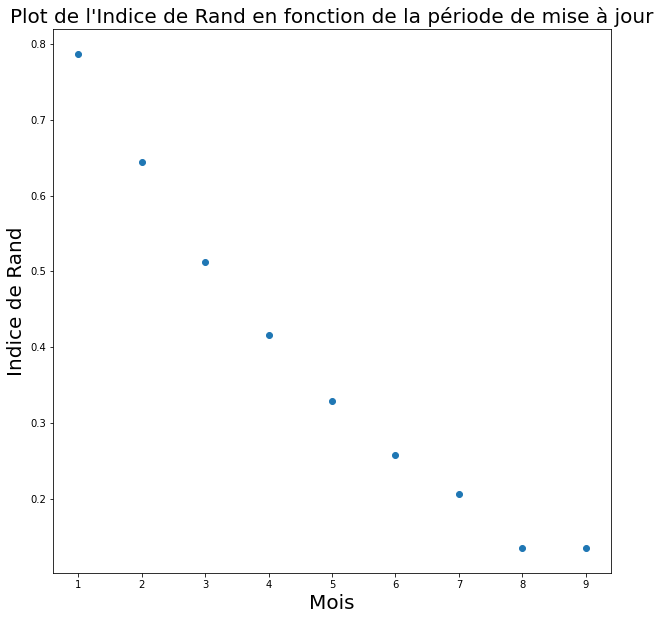

In [ ]:
plt.figure(1,figsize=(10, 10))
plt.scatter(resultats_stabilite['Période'], resultats_stabilite['ARI'])
plt.ylabel("Indice de Rand", fontsize=20)
plt.xlabel("Mois", fontsize=20)
plt.title('Plot de l\'Indice de Rand en fonction de la période de mise à jour', fontsize=20)

Les résultats montrent que plus la période de temps entre 2 segmentations est grande, plus les groupes associés à chaque client sont différents. Pour une segmentation optimale des clients, il faudrait faire une mise à jour de la segmentation à une fréquence de 3 mois (Indide de Rand = 0.5).

# **SEGMENTATION AVEC LES AUTRES INDICATEURS**

In [ ]:
# Préparation des données

var_quali = ['statut_livraison', 'emplacement_vendeur_mode', 'payment_type_credit_card_mode', 'product_category_name_english_mode']
features = list(data2017.columns[3:])

X_amelio = data2017[features].copy()
X_amelio.describe(include='all')

,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode
count,41042.000000,41042.000000,41042.000000,41042.000000,41042.000000,41042,41042.000000,41042.000000,41042.000000,41042.000000,41042.000000,41042.000000,41042.000000,41042,41042.000000,41042,41042.000000,41042
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,NaN,12
top,NaN,NaN,NaN,NaN,NaN,Livré,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non local,NaN,credit_card,NaN,meuble
freq,NaN,NaN,NaN,NaN,NaN,39977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27463,NaN,30802,NaN,7911
mean,385.502558,1.028580,142.893104,1.211174,1.138456,NaN,20.729480,4.091458,2.891529,25.667703,2.257398,2223.446247,16694.563388,NaN,5.835671,NaN,3.065738,NaN
std,98.969357,0.176842,228.594936,0.670935,0.526266,NaN,12.392930,1.325538,12.818581,77.512770,1.716599,3931.643126,25382.898373,NaN,5.481642,NaN,2.809605,NaN
min,246.000000,1.000000,2.290000,1.000000,1.000000,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,50.000000,288.000000,NaN,0.000000,NaN,1.000000,NaN
25%,294.000000,1.000000,48.000000,1.000000,1.000000,NaN,11.748065,4.000000,1.000000,7.000000,1.000000,300.000000,3006.000000,NaN,2.203650,NaN,1.000000,NaN
50%,370.000000,1.000000,89.000000,1.000000,1.000000,NaN,18.288832,5.000000,1.000000,11.000000,2.000000,800.000000,7680.000000,NaN,4.316824,NaN,2.000000,NaN
75%,461.000000,1.000000,156.000000,1.000000,1.000000,NaN,27.080963,5.000000,3.000000,17.000000,3.000000,1900.000000,19872.000000,NaN,7.687457,NaN,4.000000,NaN


## Algorithme du KMeans

In [ ]:
data2017_encode = data2017[features].copy()

labelencoder=LabelEncoder()
for col in var_quali:
  data2017_encode[col] = labelencoder.fit_transform(data2017_encode[col])

data2017_encode

,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode
0,542,1,69.00,1,1.0,0,19.972164,3.0,1.0,26.0,3.0,1500.0,43750.0,1,4.717804,1,8.0,0
1,326,1,25.99,1,1.0,0,40.417240,4.0,1.0,20.0,5.0,150.0,1045.0,1,22.320099,1,4.0,11
2,293,1,180.00,1,1.0,0,8.578394,5.0,4.0,13.0,3.0,6050.0,528.0,0,1.511542,1,6.0,11
3,548,1,135.00,1,1.0,0,10.071942,4.0,6.0,5.0,6.0,2250.0,6600.0,1,2.376671,1,3.0,7
4,412,1,13.90,1,1.0,0,52.068966,3.0,4.0,16.0,1.0,200.0,4800.0,1,7.499124,1,2.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41037,260,1,58.00,1,1.0,0,20.721706,5.0,0.0,9.0,1.0,213.0,1638.0,1,3.544398,0,1.0,2
41038,452,1,1570.00,2,2.0,0,24.059939,5.0,4.0,28.0,1.0,30000.0,251625.0,1,18.180999,1,10.0,9
41039,267,1,64.89,1,1.0,0,23.279735,4.0,5.0,30.0,2.0,1720.0,32076.0,1,14.005715,1,1.0,3
41040,573,1,89.90,1,1.0,0,20.060466,5.0,2.0,15.0,5.0,600.0,3315.0,1,14.092964,1,1.0,2


In [ ]:
X_amelio_scaled = data2017_encode[features]
X_amelio_scaled = preprocessing.scale(X_amelio_scaled)

In [ ]:
modele = KMeans

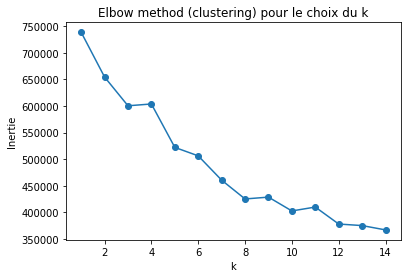

In [ ]:
## Choix de l'hyperparamètre : Méthode Elbow

resultat = []
for i in range(1, 15):
  cls = modele(n_clusters = i, n_init = 1, init = 'random')
  cls.fit(X_amelio_scaled) ## clustering sur les données normalisées
  resultat.append(cls.inertia_)
  
plt.plot(range(1, 15), resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Elbow method (clustering) pour le choix du k')
plt.show()

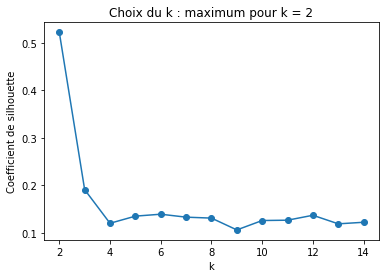

In [ ]:
## Choix de l'hyperparamètre : n_clusters

resultat = []
for i in range(2, 15):
  cls = modele(n_clusters = i, n_init = 1, init = 'random')
  cls.fit(X_amelio_scaled) ## clustering sur les données normalisées
  resultat.append(metrics.silhouette_score(X_amelio_scaled, cls.labels_))
  
plt.plot(range(2, 15), resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Coefficient de silhouette')
plt.title("Choix du k : maximum pour k = {}".format(resultat.index(max(resultat))+2))
plt.show()

In [ ]:
## Choix de n_clust
n_clust_kmeans = 8

In [ ]:
## Clustering du KMeans sur les données de 2017
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

kmeans_clustering = clustering(modele_cls, X_amelio_scaled)
kmeans_modele = kmeans_clustering[0]
labels = kmeans_clustering[1]

In [ ]:
centroids = kmeans_modele.cluster_centers_
print(centroids)

[[ 6.15127493e-02 -1.46807105e-01  1.04842155e+00 -1.44543363e-01
  -1.08808263e-01 -1.63218621e-01 -2.14270923e-01 -1.03774779e-01
  -2.15333080e-02 -1.25975781e-01 -1.04893795e-02  3.39380902e+00
   3.16217460e+00 -2.71596904e-02 -4.67031409e-02  8.14658286e-02
   5.58874603e-01 -3.62476176e-01]
 [ 5.55805070e-02 -1.61618113e-01 -1.63202045e-01 -1.40642221e-01
  -1.27188309e-01 -1.63218621e-01  3.48329000e-01  3.72574508e-02
   1.84329793e-02 -1.30982785e-01  2.17428005e-02 -1.95213405e-01
  -1.97130785e-01  6.75122801e-01  3.93260901e-01 -1.73436092e+00
  -7.27769969e-01  7.16031782e-02]
 [-1.74234480e-02 -1.61618113e-01 -2.39687060e-01 -1.80113337e-01
  -1.31025515e-01 -1.62758928e-01  3.24978289e-01  3.71379501e-02
   6.16161935e-03 -1.37970932e-01 -6.42795683e-03 -2.29773998e-01
  -2.11673766e-01  7.03013983e-01  4.00602548e-01  5.76581256e-01
  -2.09333643e-01  5.62364899e-02]
 [ 3.66873017e-01 -9.66199197e-02  1.19204755e-01 -1.14877377e-01
  -7.19816237e-02  6.12675193e+00 -3.

In [ ]:
P = pd_centers(features, centroids)
P

,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode,prediction
0,0.061513,-0.146807,1.048422,-0.144543,-0.108808,-0.163219,-0.214271,-0.103775,-0.021533,-0.125976,-0.010489,3.393809,3.162175,-0.027160,-0.046703,0.081466,0.558875,-0.362476,0
1,0.055581,-0.161618,-0.163202,-0.140642,-0.127188,-0.163219,0.348329,0.037257,0.018433,-0.130983,0.021743,-0.195213,-0.197131,0.675123,0.393261,-1.734361,-0.727770,0.071603,1
2,-0.017423,-0.161618,-0.239687,-0.180113,-0.131026,-0.162759,0.324978,0.037138,0.006162,-0.137971,-0.006428,-0.229774,-0.211674,0.703014,0.400603,0.576581,-0.209334,0.056236,2
3,0.366873,-0.096620,0.119205,-0.114877,-0.071982,6.126752,-0.034482,-1.771380,-0.026297,6.072771,-0.041138,0.051622,0.137648,0.013057,0.051716,0.018768,0.059106,0.039752,3
4,-0.102721,-0.096210,0.793450,4.114361,4.794124,-0.110306,0.312712,-0.459826,-0.021097,-0.120289,-0.245885,-0.103768,-0.077134,-0.011969,-0.027116,-0.125692,0.216881,0.039199,4
5,0.058217,-0.161618,0.722419,-0.145346,-0.069416,-0.163219,-0.793903,0.048971,0.002134,-0.151739,0.091474,0.086915,0.033741,0.306550,0.155562,0.564719,1.749840,-0.171734,5
6,-0.063120,-0.161618,-0.229788,-0.168175,-0.127831,-0.163219,-0.204965,0.132421,-0.008649,-0.222604,-0.011883,-0.231098,-0.196550,-1.422133,-0.798226,-0.035800,-0.343794,0.019825,6
7,-0.132412,5.872674,-0.056565,2.253647,0.051245,-0.092874,0.097892,0.048512,-0.025301,-0.059511,-0.111356,-0.067642,-0.059739,-0.039597,-0.066033,0.005845,0.149424,0.118466,7


In [ ]:
X_amelio = data2017[features]

X_amelio = pd.concat([X_amelio,pd.DataFrame(labels)], axis=1)
X_amelio.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio['clusters'] = X_amelio['clusters'].astype(str)

In [ ]:
dictionnaire_variables = {}

for i in [i for i in features if i not in var_quali]:
  dictionnaire_variables[i] = ['mean', 'std']

for i in var_quali:
  dictionnaire_variables[i] = [pd.Series.mode]

## Profils des clients 
profils_kmeans = X_amelio.groupby(['clusters']).agg(dictionnaire_variables)
profils_kmeans

nombre_jours  ... product_category_name_english_mode
                 mean  ...                               mode
clusters               ...                                   
0          391.590361  ...                             meuble
1          391.022487  ...                               tech
2          383.763046  ...                               tech
3          421.811303  ...                             meuble
4          375.336488  ...                             meuble
5          391.279091  ...                             divers
6          379.255723  ...                             meuble
7          372.397950  ...                             meuble

[8 rows x 32 columns]

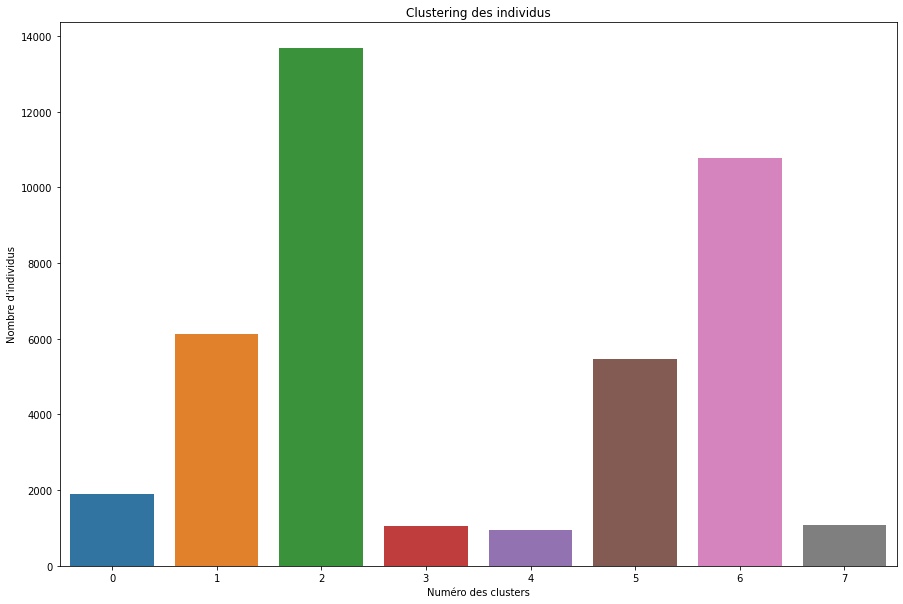

In [ ]:
## Répartition des individus entre les groupes
repartition(X_amelio)

Les résultats de la segmentation avec le KMeans montrent 8 groupes de clients avec les profils suivants : 
* groupe 0 : les clients ayant beaucoup dépensé, sur des produits très lourds et volumineux
* groupe 1 : les clients ayant payé beaucoup de frais de transport avec une grande distance vendeur-client sur de petits produits majoritairement de tech, ayant répondu à l'enquête de satisfaction après une longue période et ayant utilisé un autre type de paiement que la carte de crédit
* groupe 2 : les clients ayant peu dépensé et ayant payé beaucoup de frais de transport avec une grande distance vendeur-client sur des produits petits et légers majoritairement de tech 
* groupe 3 : les clients anciens insatisfait non livrés
* groupe 4 : les clients ayant beaucoup dépensé en achetant plusieurs produits à partir de peu de photos des produits
* groupe 5 : les clients ayant payé peu de frais de transport, ayant fait beaucoup de versements sur des produits majoritairement divers
* groupe 6 : les clients très satisfaits ayant peu dépensé sur des produits légers et ayant été livrés très rapidement avec une courte distance vendeur-client en commandant majoritairement localement
* groupe 7 : les clients anciens ayant fait plusieurs commandes en achetant plusieurs produits peu volumineux

Les groupes 2 et 6 sont beaucoup représentés dans le jeu de données, contrairement aux groupes 3, 4 et 7.

In [ ]:
## Basic radar chart

X_amelio_scaled = pd.concat([pd.DataFrame(X_amelio_scaled, columns = list(data2017_encode.columns)),pd.DataFrame(labels)], axis=1)
X_amelio_scaled.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio_scaled['clusters'] = X_amelio_scaled['clusters'].astype(str)

df = X_amelio_scaled.groupby(['clusters']).mean()

dt = pd.DataFrame(dict(r=list(df.iloc[0]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 0')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[1]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 1')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[2]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 2')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[3]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 3')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[4]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 4')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[5]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 5')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[6]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 6')
fig.show()

dt = pd.DataFrame(dict(r=list(df.iloc[7]), theta = df.columns))
fig = px.line_polar(dt, r='r', theta='theta', line_close=True, title = 'Profil 7')
fig.show()

In [ ]:
## Evaluation du clustering
resultats_KMeans = evaluation_custering('KMeans', X_amelio_scaled, labels, {'n_clusters' : n_clust_kmeans}, kmeans_clustering[2])

## Algorithme du KModes

In [ ]:
X_amelio_quali = data2017[var_quali].copy()

In [ ]:
modele = KModes

In [ ]:
## Choix de l'hyperparamètre : n_clusters

resultat = []
for i in range(1, 15):
  cls = modele(n_clusters = i, init='random', n_init=5, verbose=1)
  cls.fit(X_amelio_quali) ## clustering sur les données normalisées
  resultat.append(cls.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 58015.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 58015.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 58015.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 58015.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 58015.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 49051.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 51733.0
Init: initializing centroids
Init: initializing clusters
Starting iteration

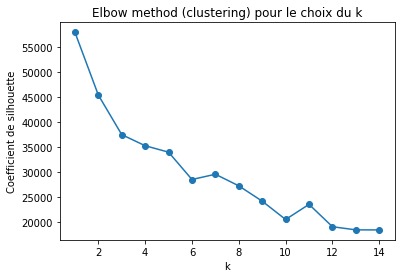

In [ ]:
plt.plot(range(1, 15), resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Coefficient de silhouette')
plt.title('Elbow method (clustering) pour le choix du k')
plt.show()

In [ ]:
## Choix de n_clust
n_clust_KModes = 6

In [ ]:
## Clustering du KModes sur les données de 2017
modele_cls = modele(n_clusters = n_clust_KModes, random_state = 0)

KModes_clustering = clustering(modele_cls, X_amelio_quali)
KModes_modele = KModes_clustering[0]
labels = KModes_clustering[1]

In [ ]:
# X_amelio_quali = data2017[var_quali]

X_amelio_quali = pd.concat([X_amelio_quali,pd.DataFrame(labels)], axis=1)
X_amelio_quali.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio_quali['clusters'] = X_amelio_quali['clusters'].astype(str)

In [ ]:
dictionnaire_variables = {}

for i in var_quali:
  dictionnaire_variables[i] = [pd.Series.mode]

## Profils des clients 
profils_KModes = X_amelio_quali.groupby(['clusters']).agg(dictionnaire_variables)
profils_KModes

,statut_livraison,emplacement_vendeur_mode,payment_type_credit_card_mode,product_category_name_english_mode
,mode,mode,mode,mode
clusters,,,,
0,Livré,Non local,credit_card,meuble
1,Livré,Local,autre,divers
2,Livré,Local,credit_card,tech
3,Livré,Non local,autre,tech
4,Non livré,Non local,credit_card,divers
5,Non livré,Local,credit_card,meuble


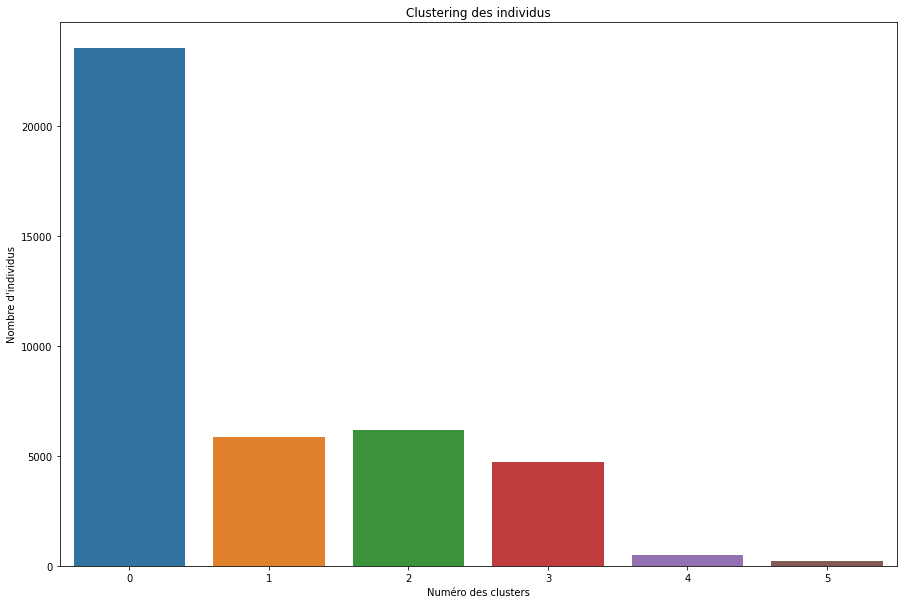

In [ ]:
## Répartition des individus entre les groupes
repartition(X_amelio_quali)

Les résultats de la segmentation avec le KMeans montrent 6 groupes de clients avec les profils suivants : 
* groupe 0 : les clients ne commandant pas localement majoritairement des meubles
* groupe 1 : les clients commandant localement majoritairement des produits divers et ne payant pas avec une carte de crédit
* groupe 2 : les clients commandant localement majoritairement des produits de tech
* groupe 3 : les clients ne commandant pas localement majoritairement des produits de tech et ne payant pas avec une carte de crédit

* groupe 4 : les clients n'ayant pas été livrés ne commandant pas localement majoritairment des produits divers 
* groupe 5 : les clients n'ayant pas été livrés commandant localement majoritairement des meubles

Les groupes 4 et 5 sont peu représentés puisqu'on a peu de clients n'ayant pas été livrés.

In [ ]:
X_amelio_quali_scaled = data2017[var_quali].copy()

labelencoder=LabelEncoder()
for col in var_quali:
  X_amelio_quali_scaled[col] = labelencoder.fit_transform(X_amelio_quali_scaled[col])

X_amelio_quali_scaled = X_amelio_quali_scaled[var_quali]
X_amelio_quali_scaled = preprocessing.scale(X_amelio_quali_scaled)

In [ ]:
## Evaluation du clustering
resultats_KModes = evaluation_custering('KModes', X_amelio_quali_scaled, labels, {'n_clusters' : n_clust_KModes}, KModes_clustering[2])

## Algorithme du KPrototypes

In [ ]:
X_amelio = data2017[features]
X_amelio_scaled = X_amelio.copy()

for col in X_amelio_scaled.select_dtypes(exclude='object').columns:
  X_amelio_scaled[col] = preprocessing.scale(X_amelio_scaled[col])

num_col_quali = [5, 13, 15, 17]

In [ ]:
modele = KPrototypes

In [ ]:
## Choix de l'hyperparamètre : Méthode Elbow

liste = [2, 5, 8, 10, 13, 15]
resultat = []
for i in liste:
  cls = modele(n_clusters = i, init='Cao', n_jobs = -1)
  cls.fit(X_amelio_scaled, categorical = num_col_quali) ## clustering sur les données normalisées
  resultat.append(cls.cost_)

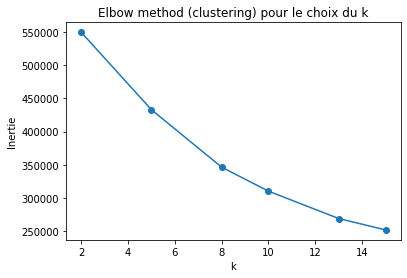

In [ ]:
plt.plot(liste, resultat, 'o-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Elbow method (clustering) pour le choix du k')
plt.show()

In [ ]:
## Choix de n_clust
n_clust_KPrototypes = 10

In [ ]:
## Clustering du KPrototypes sur les données de 2017
modele_cls = modele(n_clusters = n_clust_KPrototypes, init='Cao', n_jobs = -1)

## Calcul des vitesses d'éxécution
start_time = timeit.default_timer()

## Clustering par le modèle  
KPrototypes_modele = modele_cls.fit(X_amelio_scaled, categorical=num_col_quali)

elapsed = timeit.default_timer() - start_time

## Récupération des clusters attribués à chaque individu
labels = KPrototypes_modele.labels_

In [ ]:
labels = KPrototypes_modele.labels_

In [ ]:
X_amelio = data2017[features].copy()

X_amelio = pd.concat([X_amelio,pd.DataFrame(labels)], axis=1)
X_amelio.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio['clusters'] = X_amelio['clusters'].astype(str)

In [ ]:
dictionnaire_variables = {}

for i in [i for i in features if i not in var_quali]:
  dictionnaire_variables[i] = ['mean', 'std']

for i in var_quali:
  dictionnaire_variables[i] = [pd.Series.mode]

## Profils des clients 
profils_KPrototypes = X_amelio.groupby(['clusters']).agg(dictionnaire_variables)
profils_KPrototypes

nombre_jours  ... product_category_name_english_mode
                 mean  ...                               mode
clusters               ...                                   
0          315.077295  ...                             meuble
1          372.915584  ...                             meuble
2          389.254332  ...                             meuble
3          418.919483  ...                             meuble
4          363.185896  ...                             divers
5          381.946007  ...                               tech
6          498.691776  ...                             meuble
7          388.302146  ...                             divers
8          375.981230  ...                             meuble
9          440.936842  ...                             divers

[10 rows x 32 columns]

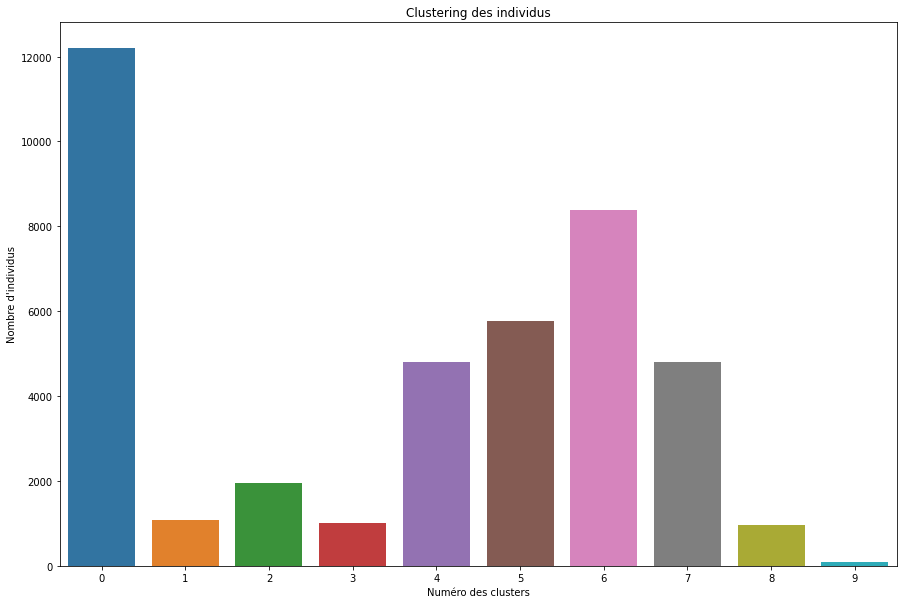

In [ ]:
## Répartition des individus entre les groupes
repartition(X_amelio)

Les résultats de la segmentation avec le KMeans montrent 10 groupes de clients avec les profils suivants : 
* groupe 0 : les clients récents ayant commandé sur de courtes distances vendeur-client
* groupe 1 : les clients ayant passé plus de 2 commandes et ayant acheté plus de 2 produits à partir de peu de photos des produits
* groupe 2 : les clients ayant beaucoup dépensé sur des produits lourds et volumineux
* groupe 3 : les clients insatisfaits non livrés
* groupe 4 : les clients ayant commandé à partir de peu de photos des produits
* groupe 5 : les clients ayant peu dépensé avec beaucoup de frais de transport sur des produits légers et petits majoritairement de tech sur de grandes distances vendeur-client
* groupe 6 : les clients anciens
* groupe 7 : les clients ayant beaucoup dépensé avec peu de frais de transport et ayant fait beaucoup de versements
* groupe 8 : les clients ayant beaucoup dépensé et ayant acheté plus de 3 produits pour 1 commande
* groupe 9 : les clients très satisfaits ayant répondu à l'enquête de satisfaction après une longue période

Le groupe 0 est beaucoup représenté, contrairement au groupe 9.

In [ ]:
X_amelio_scaled = data2017_encode[features]
X_amelio_scaled = preprocessing.scale(X_amelio_scaled)

In [ ]:
## Evaluation du clustering
resultats_KPrototypes = evaluation_custering('KPrototypes', X_amelio_scaled, labels, {'n_clusters' : n_clust_KPrototypes}, elapsed)

## Algorithme du DBSCAN

In [ ]:
data2017_encode = data2017[features].copy()

labelencoder=LabelEncoder()
for col in var_quali:
  data2017_encode[col] = labelencoder.fit_transform(data2017_encode[col])

data2017_encode

,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode
0,542,1,69.00,1,1.0,0,19.972164,3.0,1.0,26.0,3.0,1500.0,43750.0,1,4.717804,1,8.0,0
1,326,1,25.99,1,1.0,0,40.417240,4.0,1.0,20.0,5.0,150.0,1045.0,1,22.320099,1,4.0,11
2,293,1,180.00,1,1.0,0,8.578394,5.0,4.0,13.0,3.0,6050.0,528.0,0,1.511542,1,6.0,11
3,548,1,135.00,1,1.0,0,10.071942,4.0,6.0,5.0,6.0,2250.0,6600.0,1,2.376671,1,3.0,7
4,412,1,13.90,1,1.0,0,52.068966,3.0,4.0,16.0,1.0,200.0,4800.0,1,7.499124,1,2.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41037,260,1,58.00,1,1.0,0,20.721706,5.0,0.0,9.0,1.0,213.0,1638.0,1,3.544398,0,1.0,2
41038,452,1,1570.00,2,2.0,0,24.059939,5.0,4.0,28.0,1.0,30000.0,251625.0,1,18.180999,1,10.0,9
41039,267,1,64.89,1,1.0,0,23.279735,4.0,5.0,30.0,2.0,1720.0,32076.0,1,14.005715,1,1.0,3
41040,573,1,89.90,1,1.0,0,20.060466,5.0,2.0,15.0,5.0,600.0,3315.0,1,14.092964,1,1.0,2


In [ ]:
X_amelio_scaled = data2017_encode[features]
X_amelio_scaled = preprocessing.scale(X_amelio_scaled)

In [ ]:
modele = DBSCAN

In [ ]:
## Choix des hyperparamètres : eps et min_samples

x_eps = [i/10 for i in list(range(10, 31))]

tab_hyperparametres = pd.DataFrame(columns=['eps','min_samples', 'coeff_silhouette'])

for j in range(2, 11, 2):
  for i in x_eps:
    cls = modele(eps = i, min_samples = j)
    cls.fit(X_amelio_scaled) ## clustering sur les données normalisées
    tab_hyperparametres = tab_hyperparametres.append({'eps' : i, 'min_samples' : j, 'coeff_silhouette' : metrics.silhouette_score(X_amelio_scaled, cls.labels_)} , ignore_index=True)

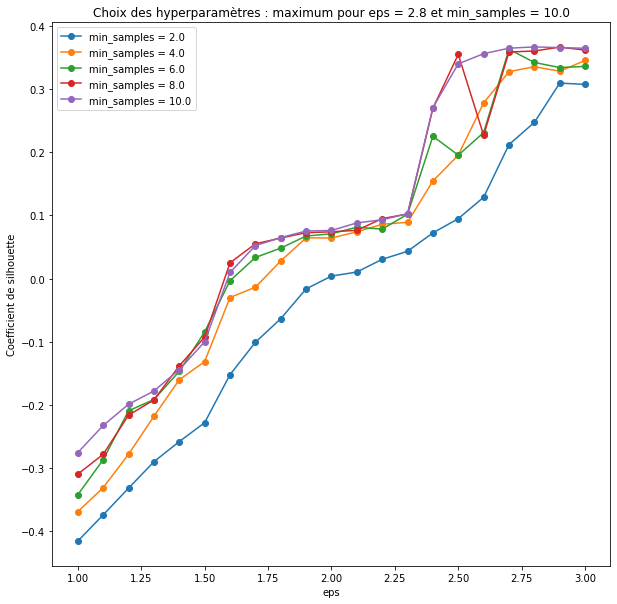

In [ ]:
plt.figure(figsize=(10,10))
for j in list(tab_hyperparametres['min_samples'].unique()):
  plt.plot(x_eps, list(tab_hyperparametres[tab_hyperparametres['min_samples'] == j]['coeff_silhouette']), 'o-', label='min_samples = {}'.format(j))
plt.legend()
plt.xlabel('eps')
plt.ylabel('Coefficient de silhouette')
plt.title("Choix des hyperparamètres : maximum pour eps = {} et min_samples = {}".format(tab_hyperparametres[tab_hyperparametres['coeff_silhouette'] == tab_hyperparametres['coeff_silhouette'].max()]['eps'].values[0], tab_hyperparametres[tab_hyperparametres['coeff_silhouette'] == tab_hyperparametres['coeff_silhouette'].max()]['min_samples'].values[0]))
plt.show()

In [ ]:
## Choix de eps et min_samples
eps_choisi = 2.8
min_samples_choisi = 10

In [ ]:
## Choix de eps et min_samples
eps_choisi = 2.5 # 3.0 
min_samples_choisi = 8 # 10.0 

In [ ]:
## Clustering du DBSCAN sur les données de 2017
modele_cls = modele(eps = eps_choisi, min_samples = min_samples_choisi)

DBSCAN_clustering = clustering(modele_cls, X_amelio_scaled)
DBSCAN_modele = DBSCAN_clustering[0]
labels = DBSCAN_clustering[1]

In [ ]:
X_amelio = data2017[features]

X_amelio = pd.concat([X_amelio,pd.DataFrame(labels)], axis=1)
X_amelio.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio['clusters'] = X_amelio['clusters'].astype(str)

In [ ]:
dictionnaire_variables = {}

for i in [i for i in features if i not in var_quali+['customer_zip_code_prefix']]:
  dictionnaire_variables[i] = ['mean', 'std']

for i in var_quali:
  dictionnaire_variables[i] = [pd.Series.mode]

## Profils des clients 
profils_DBSCAN = X_amelio.groupby(['clusters']).agg(dictionnaire_variables)
profils_DBSCAN

nombre_jours  ... product_category_name_english_mode
                 mean  ...                               mode
clusters               ...                                   
-1         408.446984  ...                             meuble
0          384.538197  ...                             meuble
1          414.661220  ...                             meuble
2          369.139614  ...                             meuble
3          363.129032  ...                            loisirs

[5 rows x 32 columns]

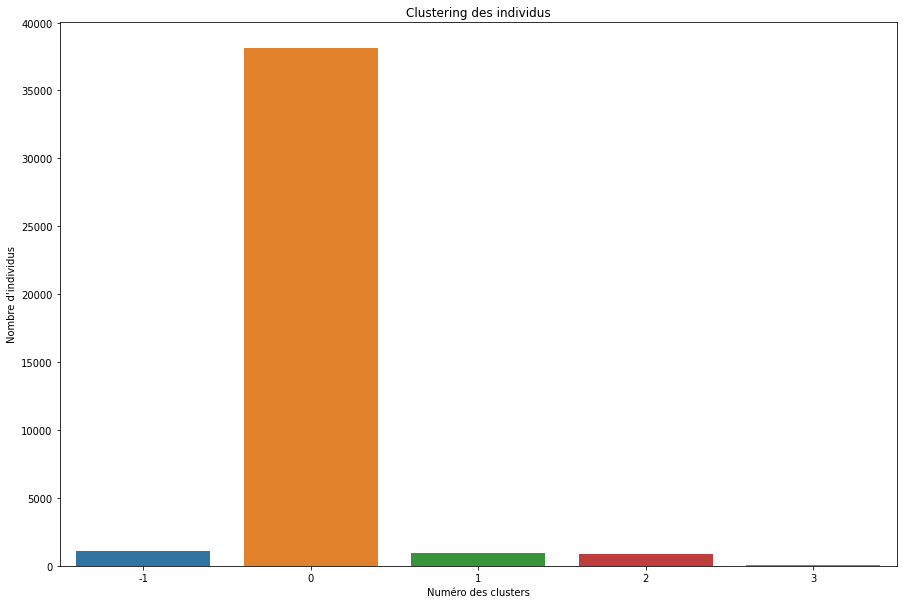

In [ ]:
## Répartition des individus entre les groupes
repartition(X_amelio)

Les résultats de la segmentation avec le DBSCAN montrent 4 groupes de clients avec les profils suivants (le label -1 correspond au bruit) : 
* groupe 0 : les clients ayant répondu à l'enquête de satisfaction après une longue période et ayant commandé des produits lourds et volumineux
* groupe 1 : les clients anciens insatisfaits non livrés 
* groupe 2 : les clients ayant commandé 2 fois
* groupe 3 : les clients récents très satisfaits ayant commandé 3 fois, ayant peu dépensé sur plusieurs produits légers à partir de peu de photos des produits majoritairement de loisirs et ayant payé beaucoup de frais de transport 

Le groupe 1 et 2 représentent la majorité du jeu de données.

In [ ]:
## Evaluation du clustering
resultats_DBSCAN = evaluation_custering('DBSCAN', X_amelio_scaled, labels, {'eps' : eps_choisi, 'min_samples' : min_samples_choisi}, DBSCAN_clustering[2])

## Comparaison des modèles

In [ ]:
tab_resultats_2 = pd.DataFrame(np.nan, index=np.arange(0), columns=['Modèle', 'nombre_paramètre', 'Coefficient_silhouette', 'Indice_Calinski_Harabasz', 'Temps_execution']) 
tab_resultats_2

,Modèle,nombre_paramètre,Coefficient_silhouette,Indice_Calinski_Harabasz,Temps_execution


In [ ]:
tab_resultats_2.loc[0] = resultats_KMeans
tab_resultats_2.loc[1] = resultats_KModes
tab_resultats_2.loc[2] = resultats_KPrototypes
tab_resultats_2.loc[3] = resultats_DBSCAN
tab_resultats_2

,Modèle,nombre_paramètre,Coefficient_silhouette,Indice_Calinski_Harabasz,Temps_execution
0,KMeans,{'n_clusters': 8},0.150783,4336.398953,2.676288
1,KModes,{'n_clusters': 6},-0.158123,1208.732633,24.068779
2,KPrototypes,{'n_clusters': 10},0.107504,3850.251145,1486.568557
3,DBSCAN,"{'eps': 2.8, 'min_samples': 10}",0.387440,2448.261386,103.694393


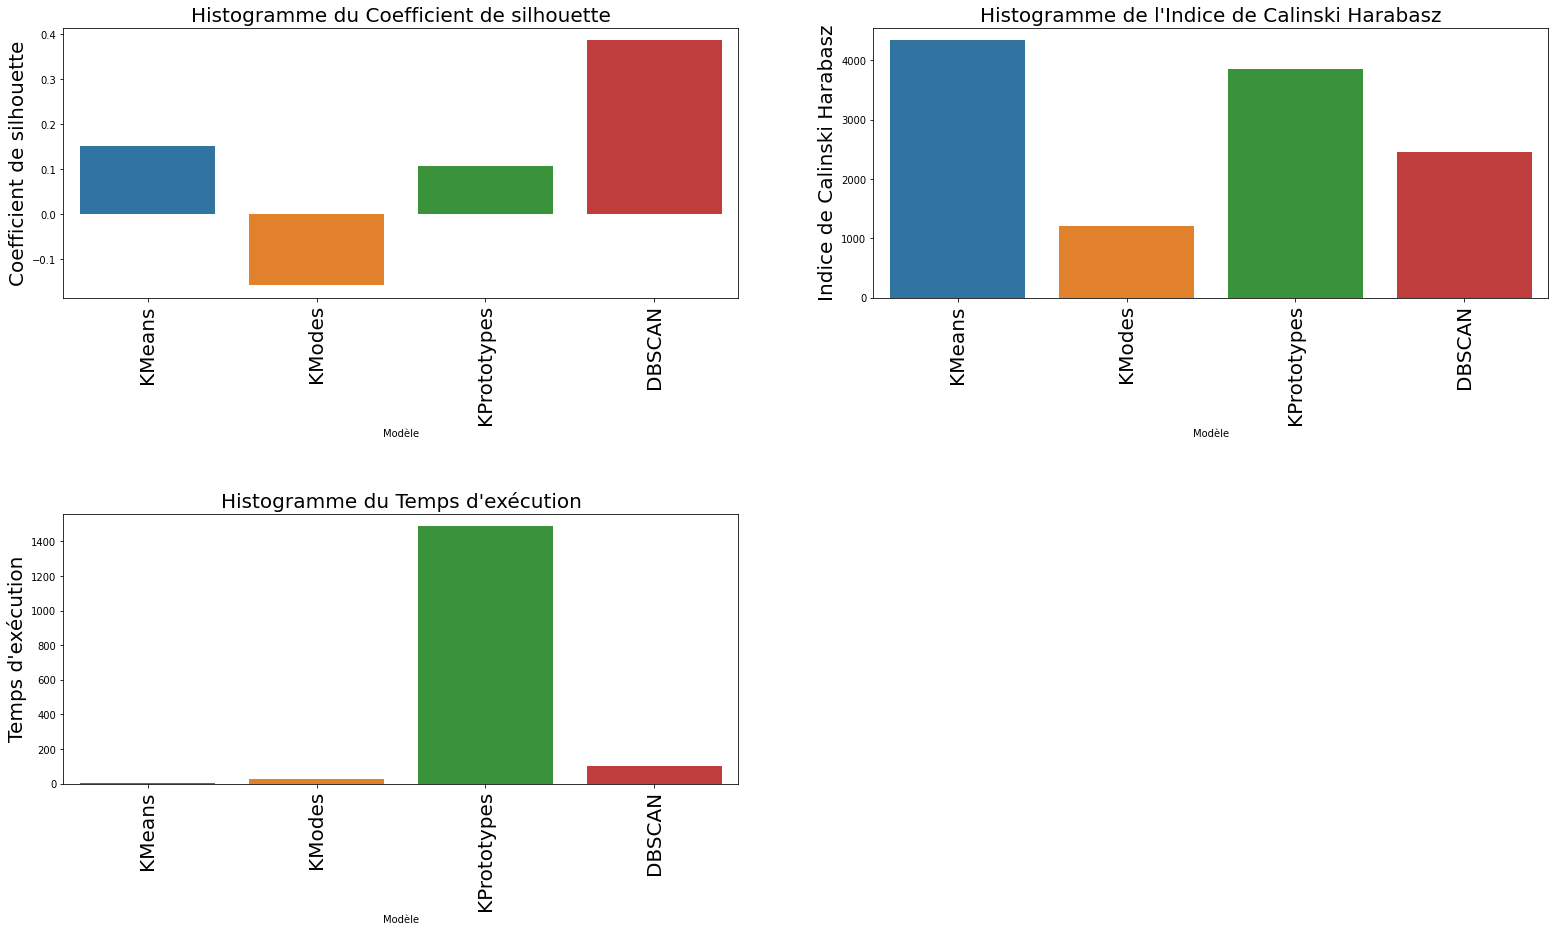

In [ ]:
plt.figure(figsize=(15,15))

plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.2, hspace = 0.8)

plt.subplot(2,2,1)
sns.barplot(x=tab_resultats_2['Modèle'],y=tab_resultats_2['Coefficient_silhouette'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Coefficient de silhouette", fontsize=20)
plt.title('Histogramme du Coefficient de silhouette', fontsize=20)

plt.subplot(2,2,2)
sns.barplot(x=tab_resultats_2['Modèle'],y=tab_resultats_2['Indice_Calinski_Harabasz'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Indice de Calinski Harabasz", fontsize=20)
plt.title('Histogramme de l\'Indice de Calinski Harabasz', fontsize=20)

plt.subplot(2,2,3)
sns.barplot(x=tab_resultats_2['Modèle'],y=tab_resultats_2['Temps_execution'])
plt.xticks(fontsize=20, rotation=90)
plt.ylabel("Temps d\'exécution", fontsize=20)
plt.title('Histogramme du Temps d\'exécution', fontsize=20)

plt.show()

Le modèle optimal sélectionné est le KMeans parmi les modèles testés. Le KPrototypes ne semble pas apporter plus d'informations dans les groupes et il est très long à calculer. Le DBSCAN ne différencie pas les individus puisque la majorité se retrouve dans le cluster 0.

## Etude de la stabilité

In [ ]:
## Création des différents DataFrames

features = list(data2017.columns[3:])
var_quali = ['statut_livraison', 'emplacement_vendeur_mode', 'payment_type_credit_card_mode', 'product_category_name_english_mode']

X_amelio_2017_scaled = creation_data(features, data2017, var_quali)
X_amelio_1_mois_scaled = creation_data(features, data_stab_1_mois, var_quali)
X_amelio_2_mois_scaled = creation_data(features, data_stab_2_mois, var_quali)
X_amelio_3_mois_scaled = creation_data(features, data_stab_3_mois, var_quali)
X_amelio_4_mois_scaled = creation_data(features, data_stab_4_mois, var_quali)
X_amelio_5_mois_scaled = creation_data(features, data_stab_5_mois, var_quali)
X_amelio_6_mois_scaled = creation_data(features, data_stab_6_mois, var_quali)
X_amelio_7_mois_scaled = creation_data(features, data_stab_7_mois, var_quali)
X_amelio_8_mois_scaled = creation_data(features, data_stab_8_mois, var_quali)
X_amelio_9_mois_scaled = creation_data(features, data_stab_9_mois, var_quali)

In [ ]:
## Modèle sélectionné

modele = KMeans
n_clust_kmeans = 8
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

In [ ]:
features = ['customer_unique_id'] + list(data2017.columns[3:])

## Jointure des labels aux différentes périodes de temps sur le DataFrame de 2017

labels = clustering(modele_cls, X_amelio_2017_scaled)[1]
data_0 = data_concat(features, data2017, labels, 'clusters')

labels = clustering(modele_cls, X_amelio_1_mois_scaled)[1]
data_1_mois = data_concat(features, data_stab_1_mois, labels, 'clusters_1_mois')
data_0 = data_0.merge(data_1_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_2_mois_scaled)[1]
data_2_mois = data_concat(features, data_stab_2_mois, labels, 'clusters_2_mois')
data_0 = data_0.merge(data_2_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_3_mois_scaled)[1]
data_3_mois = data_concat(features, data_stab_3_mois, labels, 'clusters_3_mois')
data_0 = data_0.merge(data_3_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_4_mois_scaled)[1]
data_4_mois = data_concat(features, data_stab_4_mois, labels, 'clusters_4_mois')
data_0 = data_0.merge(data_4_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_5_mois_scaled)[1]
data_5_mois = data_concat(features, data_stab_5_mois, labels, 'clusters_5_mois')
data_0 = data_0.merge(data_5_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_6_mois_scaled)[1]
data_6_mois = data_concat(features, data_stab_6_mois, labels, 'clusters_6_mois')
data_0 = data_0.merge(data_6_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_7_mois_scaled)[1]
data_7_mois = data_concat(features, data_stab_7_mois, labels, 'clusters_7_mois')
data_0 = data_0.merge(data_7_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_8_mois_scaled)[1]
data_8_mois = data_concat(features, data_stab_8_mois, labels, 'clusters_8_mois')
data_0 = data_0.merge(data_8_mois, on = features, how = 'inner')

labels = clustering(modele_cls, X_amelio_9_mois_scaled)[1]
data_9_mois = data_concat(features, data_stab_9_mois, labels, 'clusters_9_mois')
data_0 = data_0.merge(data_9_mois, on = features, how = 'inner')

data_0

,customer_unique_id,nombre_jours,nombre_commande,moyenne_prix_commande,nombre_total_articles,moyenne_nb_articles_par_commande,statut_livraison,freight_value_pourcentage,review_score,temps_reponse_enquete,duree_livraison,product_photos_qty_moyen,product_weight_g_moyen,volume_produit_moyen,emplacement_vendeur_mode,distance_client_vendeur,payment_type_credit_card_mode,nb_versements_moyen,product_category_name_english_mode,clusters,clusters_1_mois,clusters_2_mois,clusters_3_mois,clusters_4_mois,clusters_5_mois,clusters_6_mois,clusters_7_mois,clusters_8_mois,clusters_9_mois
0,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1.0,Livré,19.972164,3.0,1.0,26.0,3.0,1500.0,43750.0,Non local,4.717804,credit_card,8.0,accessoires,5,1,0,3,7,4,6,1,5,3
1,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1.0,Livré,40.417240,4.0,1.0,20.0,5.0,150.0,1045.0,Non local,22.320099,credit_card,4.0,tech,2,6,1,1,1,2,3,3,0,1
2,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1.0,Livré,8.578394,5.0,4.0,13.0,3.0,6050.0,528.0,Local,1.511542,credit_card,6.0,tech,6,0,6,7,0,5,1,2,3,6
3,0005e1862207bf6ccc02e4228effd9a0,548,1,135.00,1,1.0,Livré,10.071942,4.0,6.0,5.0,6.0,2250.0,6600.0,Non local,2.376671,credit_card,3.0,mode,2,6,1,1,1,4,3,1,0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,412,1,13.90,1,1.0,Livré,52.068966,3.0,4.0,16.0,1.0,200.0,4800.0,Non local,7.499124,credit_card,2.0,meuble,2,6,1,1,1,2,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41037,fffb09418989a0dbff854a28163e47c6,260,1,58.00,1,1.0,Livré,20.721706,5.0,0.0,9.0,1.0,213.0,1638.0,Non local,3.544398,autre,1.0,divers,1,3,2,2,5,2,0,3,2,4
41038,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,2,2.0,Livré,24.059939,5.0,4.0,28.0,1.0,30000.0,251625.0,Non local,18.180999,credit_card,10.0,sante_et_beaute,0,7,3,6,2,3,2,0,7,2
41039,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,1,1.0,Livré,23.279735,4.0,5.0,30.0,2.0,1720.0,32076.0,Non local,14.005715,credit_card,1.0,enfance,2,6,1,1,1,4,3,1,0,1
41040,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1.0,Livré,20.060466,5.0,2.0,15.0,5.0,600.0,3315.0,Non local,14.092964,credit_card,1.0,divers,2,6,1,1,1,4,3,1,0,1


In [ ]:
data_0.isnull().sum(axis = 0)

customer_unique_id                    0
nombre_jours                          0
nombre_commande                       0
moyenne_prix_commande                 0
nombre_total_articles                 0
moyenne_nb_articles_par_commande      0
statut_livraison                      0
freight_value_pourcentage             0
review_score                          0
temps_reponse_enquete                 0
duree_livraison                       0
product_photos_qty_moyen              0
product_weight_g_moyen                0
volume_produit_moyen                  0
emplacement_vendeur_mode              0
distance_client_vendeur               0
payment_type_credit_card_mode         0
nb_versements_moyen                   0
product_category_name_english_mode    0
clusters                              0
clusters_1_mois                       0
clusters_2_mois                       0
clusters_3_mois                       0
clusters_4_mois                       0
clusters_5_mois                       0


In [ ]:
## Résultats de la stabilité du modèle
labels_X_mois = list(data_0.columns[-9:])

ARI = []
for i in labels_X_mois:
  ARI.append(metrics.adjusted_rand_score(data_0['clusters'], data_0[i]))

resultats_stabilite = pd.DataFrame(list(zip(list(range(1, 10)), ARI)), columns = ['Période','ARI'])
resultats_stabilite

,Période,ARI
0,1,0.982816
1,2,0.964426
2,3,0.956821
3,4,0.942146
4,5,0.589606
5,6,0.809792
6,7,0.563550
7,8,0.804699
8,9,0.804211


Text(0.5, 1.0, "Plot de l'Indice de Rand en fonction de la période de mise à jour")

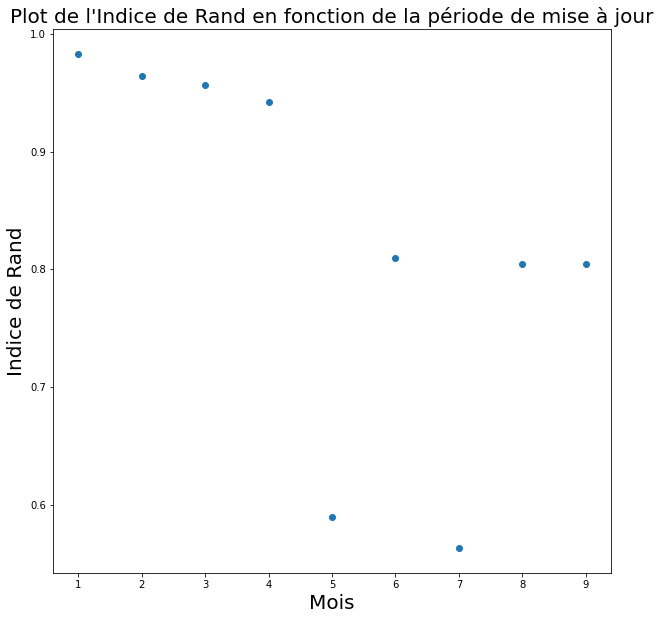

In [ ]:
plt.figure(1,figsize=(10, 10))
plt.scatter(resultats_stabilite['Période'], resultats_stabilite['ARI'])
plt.ylabel("Indice de Rand", fontsize=20)
plt.xlabel("Mois", fontsize=20)
plt.title('Plot de l\'Indice de Rand en fonction de la période de mise à jour', fontsize=20)

Les résultats montrent que plus la période de temps entre 2 segmentations est grande, plus les groupes associés à chaque client sont différents. Pour une segmentation optimale des clients, il faudrait faire une mise à jour de la segmentation à une fréquence de 5 mois (Indide de Rand = 0.6).

# REDUCTION DIMENSIONNELLE

## Sur la segmentation RFM

On peut réaliser une Analyse en Composantes Principales (ACP) sur les variables des indicateurs RFM en fonction des 6 groupes trouvés via le clustering.

In [ ]:
## Préparation des données

features = ['nombre_jours',	'nombre_commande',	'moyenne_prix_commande']
X_rfm = data2017[features].copy()

In [ ]:
modele = KMeans

X_rfm_scaled = preprocessing.scale(X_rfm)

## Choix de n_clust
n_clust_kmeans = 4

## Clustering du KMeans sur les données de 2017
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

kmeans_clustering = clustering(modele_cls, X_rfm_scaled)
kmeans_modele = kmeans_clustering[0]
labels = kmeans_clustering[1]

## Association des numéro des clusters
X_rfm = pd.concat([X_rfm,pd.DataFrame(labels)], axis=1)
X_rfm.rename(columns={0 : 'clusters'}, inplace = True)
X_rfm['clusters'] = X_rfm['clusters'].astype(str)

labels = list(X_rfm['clusters'])

In [ ]:
## Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_rfm[features])
X_scaled = std_scale.transform(X_rfm[features])

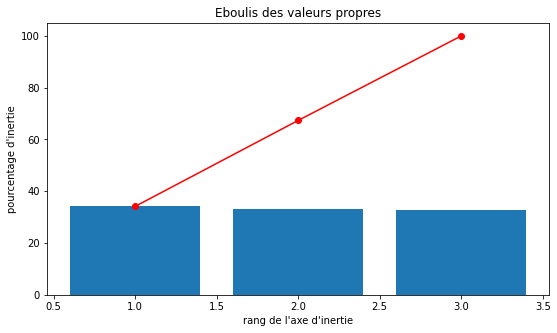

In [ ]:
## Choix du nombre de composantes à calculer
n_comp = 3

## Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

## Eboulis des valeurs propres
plt.rcParams["figure.figsize"] = (9, 5)
display_scree_plot(pca)

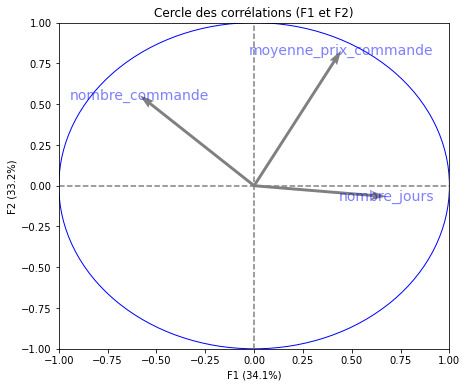

In [ ]:
## Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

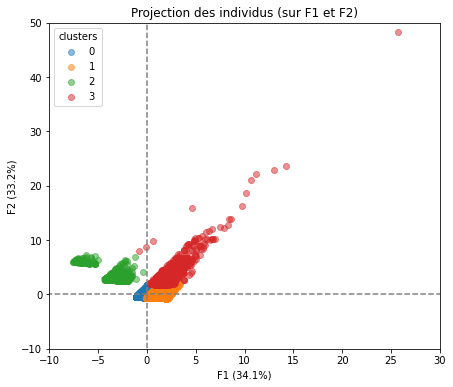

In [ ]:
# Projection des individus sur le 1er plan factoriel

alpha = 0.5
illustrative_var = labels
illustrative_legend = 'clusters'
d1 = 0
d2 = 1
X_projected = pca.transform(X_scaled)
 
fig = plt.figure(figsize=(7,6))
i = 0

illustrative_var = np.array(illustrative_var)
for value in np.unique(illustrative_var):
  selected = np.where(illustrative_var == value)
  plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
  i = i+1
plt.legend(title = illustrative_legend)

plt.xlim([-10, 30])
plt.ylim([-10, 50])
        
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
plt.show(block=False)

## Sur la segmentation de tous les indicateurs

In [ ]:
## Préparation des données

features = list(data2017.columns[3:])
var_quali = ['statut_livraison', 'emplacement_vendeur_mode', 'payment_type_credit_card_mode', 'product_category_name_english_mode']

In [ ]:
modele = KMeans

X_amelio_scaled = creation_data(features, data2017, var_quali)

## Choix de n_clust
n_clust_kmeans = 8

## Clustering du KMeans sur les données de 2017
modele_cls = modele(n_clusters = n_clust_kmeans, random_state = 0)

kmeans_clustering = clustering(modele_cls, X_amelio_scaled)
kmeans_modele = kmeans_clustering[0]
labels = kmeans_clustering[1]

## Association des numéro des clusters
X_amelio = pd.concat([X_amelio,pd.DataFrame(labels)], axis=1)
X_amelio.rename(columns={0 : 'clusters'}, inplace = True)
X_amelio['clusters'] = X_amelio['clusters'].astype(str)

labels = list(X_amelio['clusters'])

In [ ]:
## Centrage et Réduction

data2017_encode = data2017[features].copy()

labelencoder=LabelEncoder()
for col in var_quali:
  data2017_encode[col] = labelencoder.fit_transform(data2017_encode[col])

std_scale = preprocessing.StandardScaler().fit(data2017_encode.iloc[:, :-1])
X_scaled = std_scale.transform(data2017_encode.iloc[:, :-1])

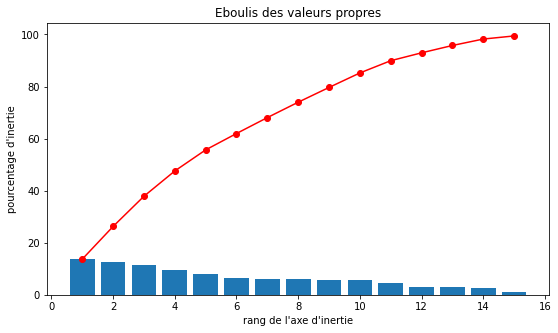

In [ ]:
## Choix du nombre de composantes à calculer
n_comp = 15

## Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

## Eboulis des valeurs propres
plt.rcParams["figure.figsize"] = (9, 5)
display_scree_plot(pca)

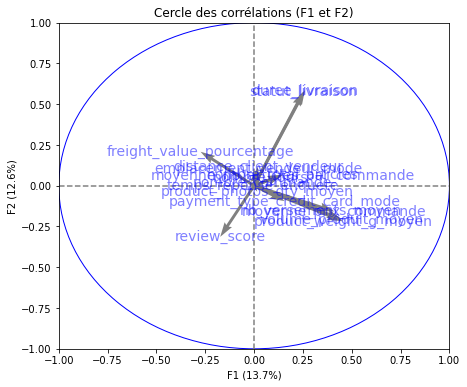

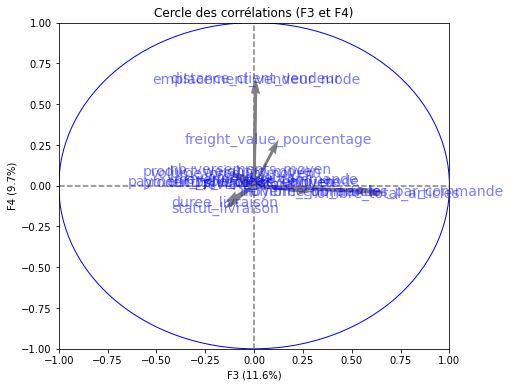

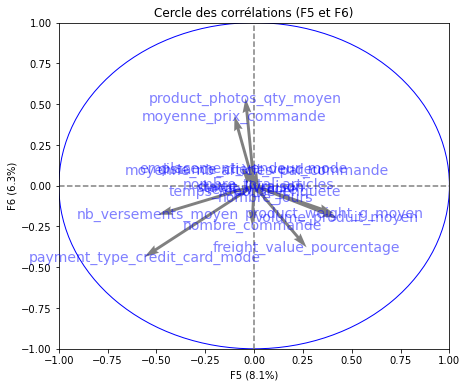

In [ ]:
## Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1), (2,3), (4,5)], labels = np.array(features))

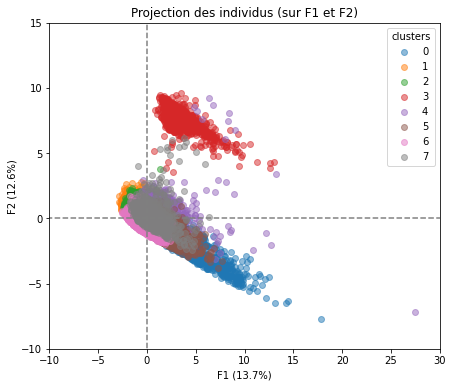

In [ ]:
# Projection des individus sur le 1er plan factoriel

alpha = 0.5
illustrative_var = labels
illustrative_legend = 'clusters'
d1 = 0
d2 = 1
X_projected = pca.transform(X_scaled)
 
fig = plt.figure(figsize=(7,6))
i = 0

illustrative_var = np.array(illustrative_var)
for value in np.unique(illustrative_var):
  selected = np.where(illustrative_var == value)
  plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
  i = i+1
plt.legend(title = illustrative_legend)

plt.xlim([-10,30])
plt.ylim([-10,15])
        
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
plt.show(block=False)